In [13]:
import os
import pathlib
import itertools
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB0

warnings.filterwarnings("ignore")
print("All modules loaded!")

All modules loaded!


In [14]:
def define_paths(data_dir):
    filepaths = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        for sub in os.listdir(class_path):
            sub_path = os.path.join(class_path, sub)
            if sub.lower() == 'masks':
                continue
            if os.path.isdir(sub_path):
                for f in os.listdir(sub_path):
                    filepaths.append(os.path.join(sub_path, f))
                    labels.append(class_name)
            else:
                filepaths.append(sub_path)
                labels.append(class_name)
    return filepaths, labels

In [15]:
def define_df(files, classes):
    return pd.DataFrame({'filepaths': files, 'labels': classes})

In [16]:
def split_data(data_dir):
    files, labels = define_paths(data_dir)
    df = define_df(files, labels)
    train_df, temp_df = train_test_split(df, train_size=0.8, random_state=123, stratify=df['labels'])
    val_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=123, stratify=temp_df['labels'])
    return train_df, val_df, test_df

In [17]:
def create_gens(train_df, val_df, test_df, batch_size=32):
    img_size = (224, 224)
    color_mode = 'rgb'

    def scalar(img):
        return img

    train_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True).flow_from_dataframe(
        train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode=color_mode, batch_size=batch_size, shuffle=True
    )

    val_gen = ImageDataGenerator(preprocessing_function=scalar).flow_from_dataframe(
        val_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode=color_mode, batch_size=batch_size, shuffle=False
    )

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
    test_gen = ImageDataGenerator(preprocessing_function=scalar).flow_from_dataframe(
        test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode=color_mode, batch_size=test_batch_size, shuffle=False
    )

    return train_gen, val_gen, test_gen

In [18]:
def show_images(gen):
    classes = list(gen.class_indices.keys())
    images, labels = next(gen)
    sample = min(len(labels), 25)

    plt.figure(figsize=(15,15))
    for i in range(sample):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i]/255)
        plt.title(classes[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

Found 16931 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.
Classes: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
Number of classes: 4


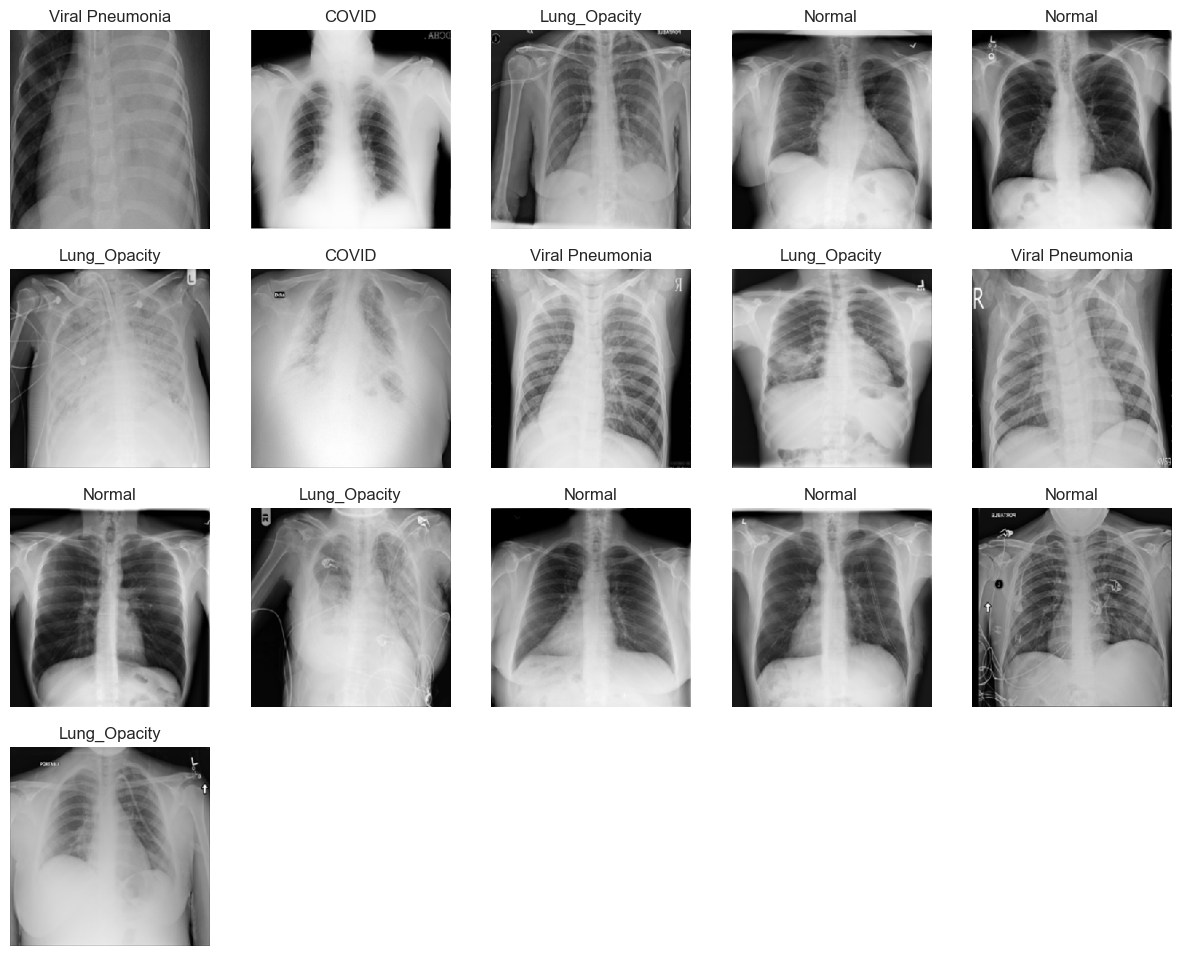

In [19]:
data_dir = "../data/covid_xray"

train_df, val_df, test_df = split_data(data_dir)
train_gen, val_gen, test_gen = create_gens(train_df, val_df, test_df, batch_size=16)

class_count = len(train_gen.class_indices)
print("Classes:", train_gen.class_indices)
print("Number of classes:", class_count)

# Display sample images
show_images(train_gen)

In [20]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu',
          kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006)),
    Dropout(0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 4,339,072 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,  # increase later if needed
    verbose=1
)

Epoch 1/10


2026-01-20 02:27:03.624222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 613/1059 ━━━━━━━━━━━━━━━━━━━━ 3:44 503ms/step - accuracy: 0.4624 - loss: 15.5202

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

In [ ]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
classes = list(test_gen.class_indices.keys())

cm = confusion_matrix(test_gen.classes, y_pred_classes)
print(cm)
print(classification_report(test_gen.classes, y_pred_classes, target_names=classes))